# [CS303]Practice 8 - Local Search: Genetic Algorithm
In this practice, you will explore how **Genetic Algorithms (GA)** work and how they can be used to search for good solutions in large, complex spaces.

You will first experiment with a **toy problem** — generating a target phrase — and then apply the same idea to solve the **N-Queens problem**.

📌 **DDL: Nov.23th**

## Evaluation Criteria

Your submission will be assessed on:

* Clear understanding of every line of your code (no blind copy-paste).
* Successful compilation of the program.
* Correctness of the program logic.
* Reasonable efficiency of the solution.

### Grading Policy

* **On-time submission:** 60–100 points
* **Late submission:** 0 points




In [37]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generating Phrases

Let’s begin with a simple but fun example: evolving random strings until one of them matches a **target phrase** (e.g., `"Genetic Algorithm"`).
Assume the length of the target phrase is known.

### Problem Formulation

1. **Representation:** Each individual is a string.
2. **Search Space:**  $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

### Designing a Genetic Algorithm

1. **Chromosome:** The string itself.
2. **Fitness Function:** Measures how close a string is to the target phrase (e.g., number of matching characters).
3. **Crossover (Mating):** Combines two parent strings to produce a new string.
4. **Mutation:** Randomly changes a few characters to maintain diversity in the population.

The following cells will guide you through the process step by step. Complete the `TODO` sections in the provided code so the program runs correctly — this will show how a GA gradually evolves a population toward the target phrase.


In [38]:
# setting up the problem
target = 'Genetic Algorithm'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size:int, gene_pool:list[str], state_length:int) -> list[str]:
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['ofaqnqgtmpIWxgWAq',
 'wGISuTdCxcWbXVRQj',
 'TmlTzY CIOuF jNXp',
 'uNPlNISggWMXxEXvu',
 'KdkBSpkrvZcNJjfoQ',
 'JHKPlzinCacjSemxy',
 'DvfmjheQFNsBIaRdO',
 'jriuLLuH ysEjjYjH',
 'SWvjoqpWCgitqFWts',
 'QYaUsyDyxCceaNPN ']

In [39]:
def fitness_fn(sample: str, target: str = target) -> int:
    # TODO: evaluate how close *sample* is to the target, e.g., number of matching characters
    score = sum(1 for a, b in zip(sample, target) if a == b)
    return score

# test
fitness_fn(init_pop[0])

0

In [40]:
def select(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    fitness_scores = [fitness_fn(individual, target) for individual in population]
    total_fitness = sum(fitness_scores)
    if total_fitness == 0:
        probabilities = [1 / len(population)] * len(population)
    else:
        epsilon = 1e-2  # small constant to avoid zero probability
        probabilities = [score + epsilon / total_fitness for score in fitness_scores]
    selected = random.choices(population, weights=probabilities, k=r)
    return selected

# test
parents = select(2, init_pop, fitness_fn)
parents

['KdkBSpkrvZcNJjfoQ', 'TmlTzY CIOuF jNXp']

In [41]:
def recombine(x: str, y: str):
    """
    TODO: combine two parents to produce an offspring
    """
    n = len(x)
    c = random.randrange(1, n - 1)  # crossover point
    child = x[:c] + y[c:]
    return child

def mutate(x: str, gene_pool: str, pmut: float):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'KdkBSpkrvOuF jNXp'

In [42]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet

    def init_population(self, pop_size):
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        # TODO: evaluate how close *sample* is to the target
        return fitness_fn(sample, self.target)

    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population

        hint: make a new individual with 
        
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        return [mutate(recombine(*select(2, population, fitness_fn)), self.alphabet, mutation_rate) for _ in range(len(population))]
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        combined = old + new
        combined.sort(key=self.fitness, reverse=True)
        return combined[:len(old)]

def genetic_algorithm(
        problem: GAProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=100
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [50]:
# now set up the parameters
ngen = 1200
max_population = 120
mutation_rate = 0.08

sid = 12410106 #TODO:  replace this with your own sid
target = f"Genetic Algorithm by {sid}" 
alphabet = "abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ123456789" # TODO: fix this: what is the search space now?

problem = PhraseGeneration(target, alphabet)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/1200,	Best: CKFPJieaAVwYKDUc 2bytP2UDmkkY,	Fitness=5
Generation: 100/1200,	Best: GGnYticfAlgRmotZmDby V2UDm1m6,	Fitness=16
Generation: 200/1200,	Best: GGnetic AlgRmothmDby 12UDc1m6,	Fitness=20
Generation: 300/1200,	Best: GGnetic AlgRrithmDby 12UDm1m6,	Fitness=22
Generation: 400/1200,	Best: GGnetic AlgorithmDby 12U1m1m6,	Fitness=24
Generation: 500/1200,	Best: GGnetic AlgorithmDby 1241m1m6,	Fitness=25
Generation: 600/1200,	Best: Genetic AlgorithmDby 1241m1m6,	Fitness=26
Generation: 700/1200,	Best: Genetic AlgorithmDby 1241m1m6,	Fitness=26
Generation: 800/1200,	Best: Genetic Algorithm by 1241m1m6,	Fitness=27
Generation: 900/1200,	Best: Genetic Algorithm by 1241m1m6,	Fitness=27
Generation: 1000/1200,	Best: Genetic Algorithm by 1241m1m6,	Fitness=27
Generation: 1100/1200,	Best: Genetic Algorithm by 1241m1m6,	Fitness=27


'Genetic Algorithm by 1241m1m6'

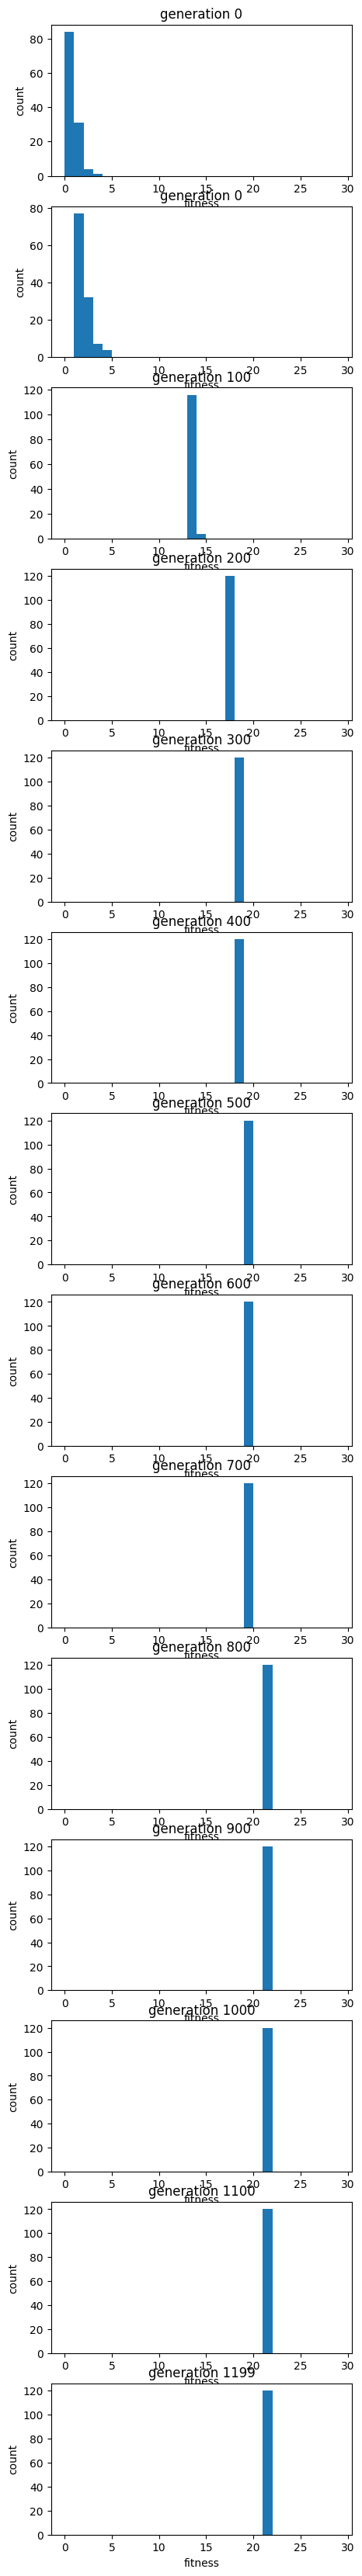

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [44]:
# visualize the evolution of the polulation
bins = np.linspace(0, len(target), len(target)+1)
plot_evolution(history, bins)
bins

## 2. N-Queens Problem

Next, we will apply the genetic algorithm to the classic **N-Queens problem**.

### Problem Formulation

1. **Representation:** The board configuration, typically represented as an array indicating queen positions.
2. **Search Space:** $n^n$, if no constraints are applied.

### Modifying the GA

To adapt GA for this problem:

* The **fitness function** should measure how many pairs of queens are not attacking each other — the goal is to **maxmize** this value.
* Other parts (representation, crossover, mutation) can remain mostly the same as in the previous example.

By comparing the two problems, you’ll see how GAs can be adapted to very different types of search spaces.


In [45]:
class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness =  n*(n-1)//2 # max number if non-attacking pairs
        self.gene_pool = [str(i) for i in range(self.n)]
    def init_population(self, pop_size):
        # TODO:alomost the same as the previous problem.
        return init_population(pop_size, self.gene_pool, self.n)

    def fitness(self, queens):
        """
        TODO
        hint: count the non-attacking pairs
        """
        attacking_pairs = 0
        n = len(queens)
        for i in range(n):
            for j in range(i + 1, n):
                if queens[i] == queens[j] or abs(int(queens[i]) - int(queens[j])) == abs(i - j):
                    attacking_pairs += 1
        return self.max_fitness - attacking_pairs
        

    def reproduce(self, population, mutation_rate):
        # TODO:alomost the same as the previous problem.
        return [mutate(recombine(*select(2, population, fitness_fn)), self.gene_pool, mutation_rate) for _ in range(len(population))]
    

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        combined = old + new
        combined.sort(key=self.fitness, reverse=True)
        return combined[:len(old)]

    def __repr__(self):
        return f"{self.n}-Queens Problem"

In [46]:
from utils import plot_NQueens
ngen = 1000
init_size = 120
mutation_rate = 0.08

n = 8
problem = NQueensProblem(n)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)


Generation: 0/1000,	Best: 15136074,	Fitness=25
Generation: 100/1000,	Best: 24603175,	Fitness=28
Generation: 200/1000,	Best: 24603175,	Fitness=28
Generation: 300/1000,	Best: 24603175,	Fitness=28
Generation: 400/1000,	Best: 24603175,	Fitness=28
Generation: 500/1000,	Best: 24603175,	Fitness=28
Generation: 600/1000,	Best: 24603175,	Fitness=28
Generation: 700/1000,	Best: 24603175,	Fitness=28
Generation: 800/1000,	Best: 24603175,	Fitness=28
Generation: 900/1000,	Best: 24603175,	Fitness=28


In [47]:
print(f"Solution for {n}-Queens: {solution}, Fitness={problem.fitness(solution)}")

Solution for 8-Queens: 24603175, Fitness=28


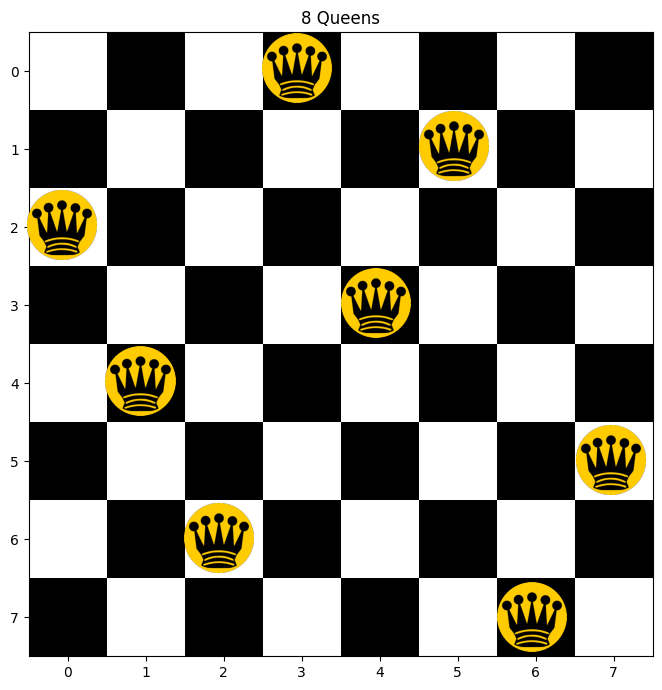

In [48]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
plot_NQueens([int(x) for x in solution])

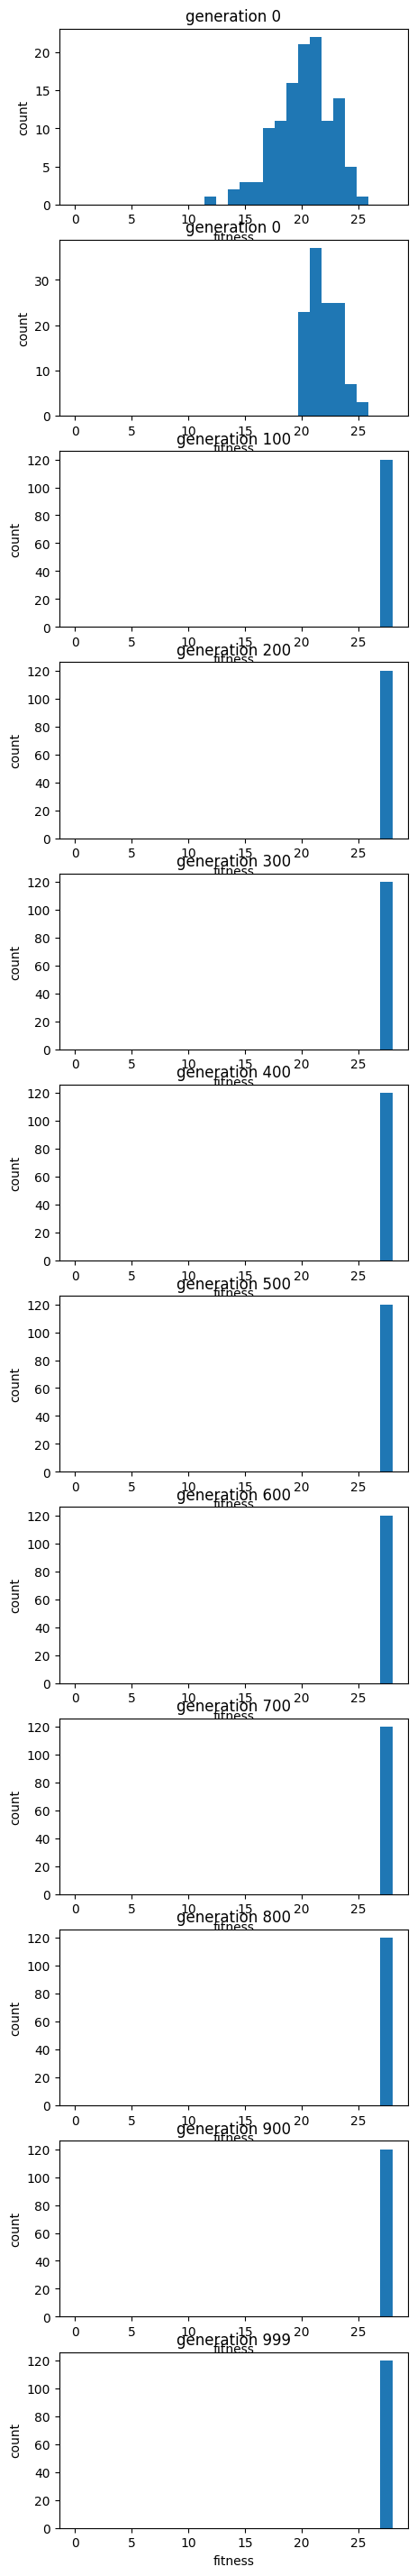

In [49]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)